In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

c:\Users\DELL\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Đọc dữ liệu từ 4 file CHEAT dataset
file_paths = {
    "init": "dataset/CHEAT-main/data/ieee-init.xlsx",
    "generation": "dataset/CHEAT-main/data/ieee-chatgpt-generation.xlsx",
    "polish": "dataset/CHEAT-main/data/ieee-chatgpt-polish.xlsx",
    "fusion": "dataset/CHEAT-main/data/ieee-chatgpt-fusion.xlsx"
}

In [3]:
dataframes = []
for label, file_path in enumerate(file_paths.values()):
    df = pd.read_excel(file_path)
    df["label"] = label  # Thêm cột nhãn
    dataframes.append(df)

In [4]:
# Gộp toàn bộ dataset
df = pd.concat(dataframes, ignore_index=True)
df = df[['abstract', 'label']].dropna()  # Xóa dòng thiếu dữ liệu


In [5]:
# Chia dữ liệu thành train và test
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["abstract"].tolist(),
    df["label"].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)

In [6]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [7]:
def tokenize_texts(texts, tokenizer, max_length=128):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

In [8]:
# Tokenize dữ liệu train và test
train_encodings = tokenize_texts(train_texts, tokenizer)
test_encodings = tokenize_texts(test_texts, tokenizer)


In [9]:
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

In [10]:
train_dataset = TextDataset(train_encodings, train_labels)
test_dataset = TextDataset(test_encodings, test_labels)

In [11]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [12]:
class RoBERTa_LSTM(nn.Module):
    def __init__(self, roberta_model_name="roberta-base", lstm_hidden_size=128, num_labels=4):
        super(RoBERTa_LSTM, self).__init__()
        self.roberta = RobertaModel.from_pretrained(roberta_model_name)  # Load RoBERTa
        self.lstm = nn.LSTM(input_size=768, hidden_size=lstm_hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(lstm_hidden_size * 2, num_labels)  # 2 * hidden_size vì LSTM là bidirectional
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids, attention_mask):
        roberta_output = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        lstm_input = roberta_output.last_hidden_state  # Lấy output từ RoBERTa
        lstm_output, _ = self.lstm(lstm_input)
        lstm_output = self.dropout(lstm_output[:, -1, :])  # Lấy output cuối của LSTM
        output = self.fc(lstm_output)
        return output

In [13]:
# Kiểm tra GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Đang sử dụng:", device)

Đang sử dụng: cuda


In [14]:
# Khởi tạo mô hình
model = RoBERTa_LSTM()
model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RoBERTa_LSTM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): La

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

In [16]:
num_epochs = 12
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for batch in progress_bar:
        optimizer.zero_grad()
        
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    print(f"🔥 Epoch {epoch+1}: Loss = {total_loss / len(train_loader):.4f}")

Epoch 1/12: 100%|██████████| 2535/2535 [09:26<00:00,  4.47it/s, loss=0.266] 


🔥 Epoch 1: Loss = 0.4610


Epoch 2/12: 100%|██████████| 2535/2535 [09:23<00:00,  4.50it/s, loss=0.396] 


🔥 Epoch 2: Loss = 0.3013


Epoch 3/12: 100%|██████████| 2535/2535 [09:01<00:00,  4.68it/s, loss=0.0349]


🔥 Epoch 3: Loss = 0.2347


Epoch 4/12: 100%|██████████| 2535/2535 [09:00<00:00,  4.69it/s, loss=0.0983] 


🔥 Epoch 4: Loss = 0.1924


Epoch 5/12: 100%|██████████| 2535/2535 [08:58<00:00,  4.71it/s, loss=0.376]  


🔥 Epoch 5: Loss = 0.1542


Epoch 6/12: 100%|██████████| 2535/2535 [08:57<00:00,  4.72it/s, loss=0.127]  


🔥 Epoch 6: Loss = 0.1357


Epoch 7/12: 100%|██████████| 2535/2535 [08:57<00:00,  4.72it/s, loss=0.33]   


🔥 Epoch 7: Loss = 0.1129


Epoch 8/12: 100%|██████████| 2535/2535 [09:18<00:00,  4.54it/s, loss=0.267]  


🔥 Epoch 8: Loss = 0.1024


Epoch 9/12: 100%|██████████| 2535/2535 [09:42<00:00,  4.35it/s, loss=0.00952]


🔥 Epoch 9: Loss = 0.0907


Epoch 10/12: 100%|██████████| 2535/2535 [09:28<00:00,  4.46it/s, loss=0.0505] 


🔥 Epoch 10: Loss = 0.0829


Epoch 11/12: 100%|██████████| 2535/2535 [09:28<00:00,  4.46it/s, loss=0.037]  


🔥 Epoch 11: Loss = 0.0742


Epoch 12/12: 100%|██████████| 2535/2535 [09:29<00:00,  4.45it/s, loss=0.0453] 

🔥 Epoch 12: Loss = 0.0715


In [22]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# In các độ đo
print("✅ Accuracy:", accuracy_score(all_labels, all_preds))
print("✅ Precision:", precision_score(all_labels, all_preds, average="weighted"))
print("✅ Recall:", recall_score(all_labels, all_preds, average="weighted"))
print("✅ F1-score:", f1_score(all_labels, all_preds, average="weighted"))

✅ Accuracy: 0.834516765285996
✅ Precision: 0.856609148299444
✅ Recall: 0.834516765285996
✅ F1-score: 0.8372044990156449


In [18]:
# ========================== 7. LƯU MÔ HÌNH ==========================
torch.save(model.state_dict(), "roberta_lstm_model.pth")
print("✅ Mô hình đã được lưu!")

✅ Mô hình đã được lưu!


In [23]:
import joblib

# Lưu mô hình
joblib.dump(model, "model_roberta_lstm.joblib")

print("✅ Mô hình đã lưu thành công dưới định dạng .joblib")


✅ Mô hình đã lưu thành công dưới định dạng .joblib


In [19]:
torch.save(model.state_dict(), "roberta_lstm_model.pt")
print("✅ Mô hình đã được lưu!")

✅ Mô hình đã được lưu!


In [24]:
def predict_text(text, model, tokenizer):
    model.eval()
    
    inputs = tokenizer(
        text,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )
    
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        _, predicted = torch.max(outputs, 1)

    return predicted.item()

text = "Jamming identification is the precondition of taking targeted anti-jamming measures, and it is very important to improve the adaptability of electronic information system to electromagnetic environment. While the most commonly used method of jamming recognition relies on expert knowledge-based feature extraction, the varied patterns and parameters of jamming can make it difficult to determine the correct feature set. Therefore, this paper introduces a deep learning approach, which automatically extracts features from the original data to identify the jamming factors of electronic information system. In order to demonstrate the effectiveness and practicability of this approach, the noise jamming factor identification of the superheterodyne receiver is introduced."
predicted_label = predict_text(text, model, tokenizer)
print(f"🔍 Nhãn dự đoán: {predicted_label}")

🔍 Nhãn dự đoán: 3


C:\Users\DELL\AppData\Local\Temp\ipykernel_21332\2110242142.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=probs, y=LABELS, palette=COLORS)
C:\Users\DELL\AppData\Local\Temp\ipykernel_21332\2110242142.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=attention_scores, y=tokenized_text, palette="coolwarm")


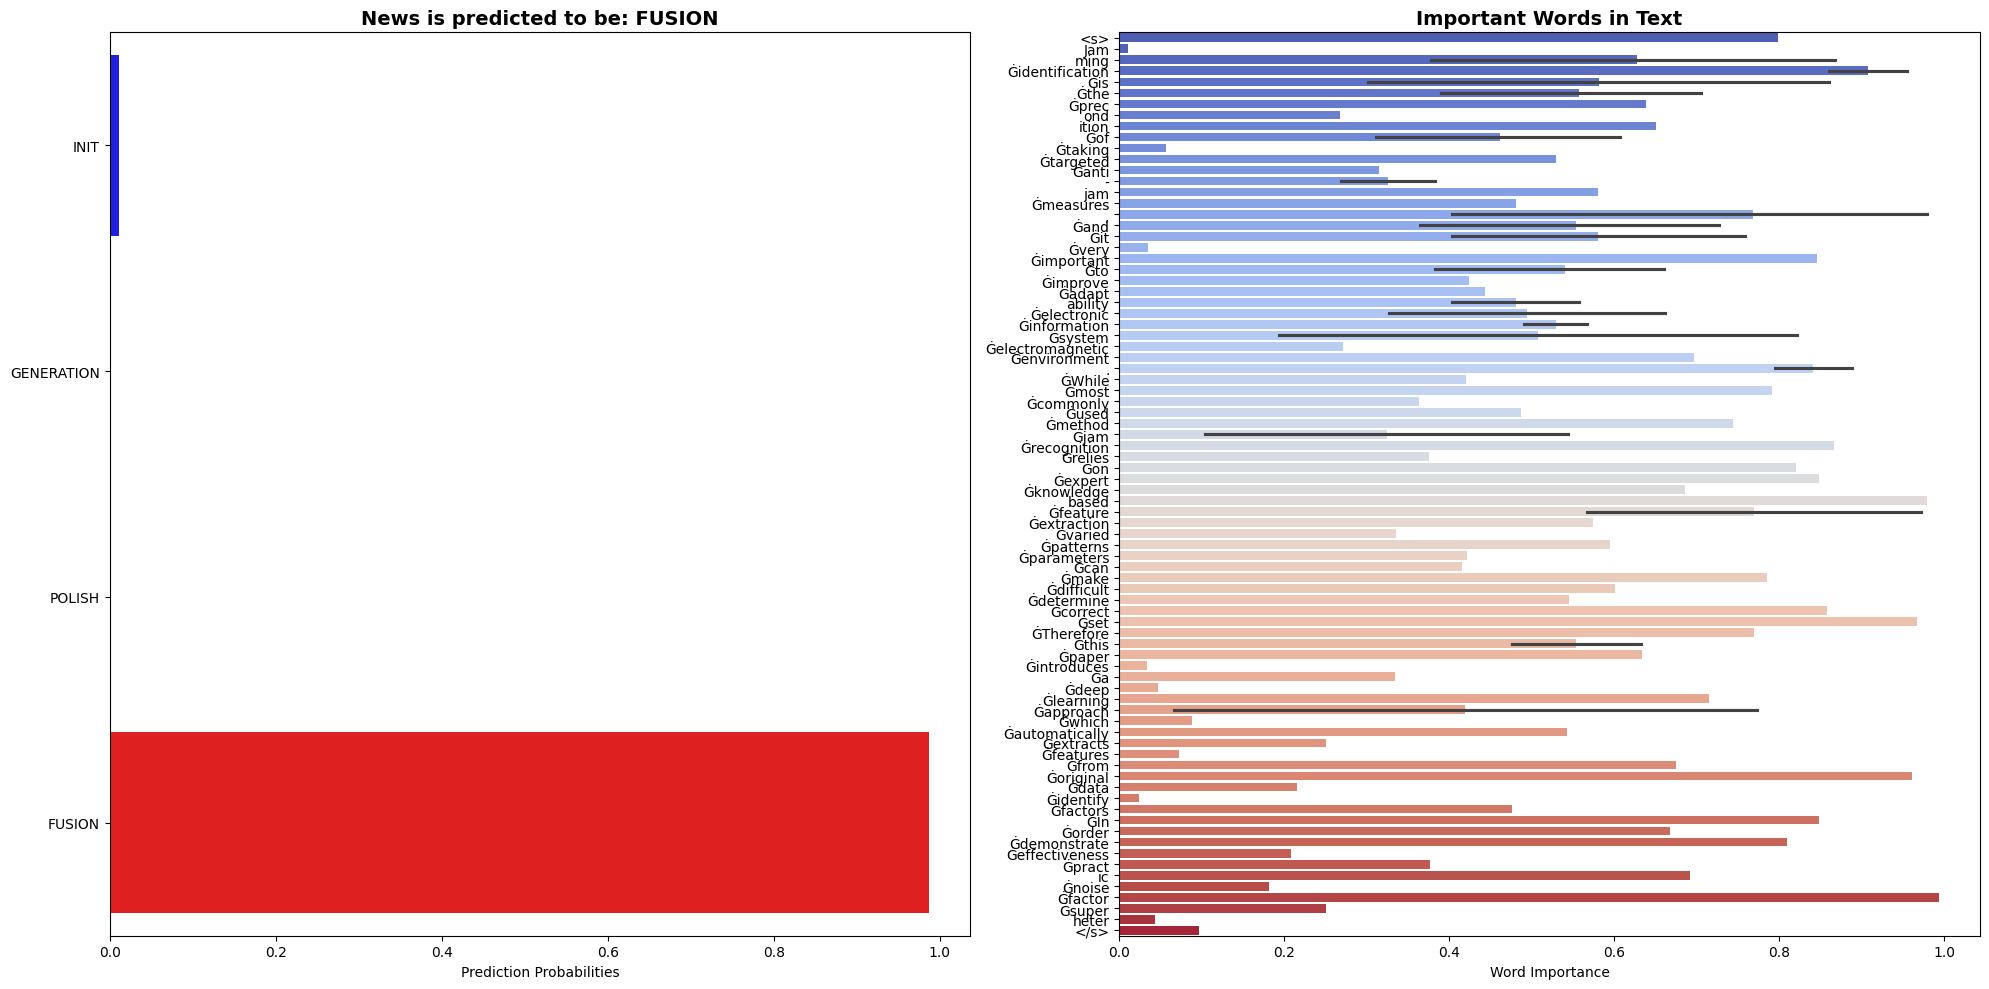


Text with highlighted words:
Jamming identification is the precondition of taking targeted anti-jamming measures, and it is very important to improve the adaptability of electronic information system to electromagnetic environment. While the most commonly used method of jamming recognition relies on expert knowledge-based feature extraction, the varied patterns and parameters of jamming can make it difficult to determine the correct feature set. Therefore, this paper introduces a deep learning approach, which automatically extracts features from the original data to identify the jamming factors of electronic information system. In order to demonstrate the effectiveness and practicability of this approach, the noise jamming factor identification of the superheterodyne receiver is introduced.


In [25]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns
from transformers import RobertaTokenizer

LABELS = ["INIT", "GENERATION", "POLISH", "FUSION"]
COLORS = ["blue", "orange", "green", "red"]

def get_prediction_with_probs(text, model, tokenizer, device="cuda"):
    model.eval()
    inputs = tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors="pt")
    
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        probs = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()[0]  # Xác suất
        predicted_label = np.argmax(probs)

    return predicted_label, probs, inputs

def plot_prediction_results(text, model, tokenizer, device="cuda"):
    predicted_label, probs, inputs = get_prediction_with_probs(text, model, tokenizer, device)
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    sns.barplot(x=probs, y=LABELS, palette=COLORS)
    plt.xlabel("Prediction Probabilities")
    plt.title(f"News is predicted to be: {LABELS[predicted_label]}", fontsize=14, fontweight="bold")
    
    tokenized_text = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    attention_scores = np.random.rand(len(tokenized_text)) 

    plt.subplot(1, 2, 2)
    sns.barplot(x=attention_scores, y=tokenized_text, palette="coolwarm")
    plt.xlabel("Word Importance")
    plt.title("Important Words in Text", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()

    highlight_text(text, tokenized_text, attention_scores)

def highlight_text(text, tokenized_text, attention_scores):
    sorted_indices = np.argsort(-attention_scores)[:5]  # Chọn 5 từ quan trọng nhất
    highlighted_text = text

    for idx in sorted_indices:
        word = tokenized_text[idx]
        if word.startswith("Ġ"):  # Loại bỏ ký tự đặc biệt của RoBERTa tokenizer
            word = word[1:]
        highlighted_text = highlighted_text.replace(word, f"\033[1;34m{word}\033[0m")  # Màu xanh

    print("\nText with highlighted words:")
    print(highlighted_text)

# Dùng thử
input_text = "Jamming identification is the precondition of taking targeted anti-jamming measures, and it is very important to improve the adaptability of electronic information system to electromagnetic environment. While the most commonly used method of jamming recognition relies on expert knowledge-based feature extraction, the varied patterns and parameters of jamming can make it difficult to determine the correct feature set. Therefore, this paper introduces a deep learning approach, which automatically extracts features from the original data to identify the jamming factors of electronic information system. In order to demonstrate the effectiveness and practicability of this approach, the noise jamming factor identification of the superheterodyne receiver is introduced."
plot_prediction_results(input_text, model, tokenizer)
